In [1]:
from exp import *

In [2]:
#export
from .nb_Tesis import *

ModuleNotFoundError: No module named '__main__.nb_Tesis'; '__main__' is not a package

In [ ]:
#export
def correct_iluminant(estimated_iluminant):
    perfect_white_light = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = perfect_white_light * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

def gamma_correction_step(image,gamma):
    return image * gamma


def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
    e = image.max(dim=1)[0].max(dim=1)[0]
    k = 1 / torch.norm(e)
    return e * k


def _correct_color_max_rgb(gamma=1):
    def closure(image):
        image = gamma_correction_step(image,gamma=gamma)
        estimated_iluminant = max_rgb(image);
        c = correct_image(image,estimated_iluminant)
        return c
    return closure


def correct_color_max_rgb(gamma,order=0):
    return TfmPixel(_correct_color_max_rgb(gamma),order=order)()

In [3]:
#export
def shades_of_gray(image, p, gamma):
    image = gamma_correction_step(image,gamma=gamma)
    e = ((image ** p).sum(dim=[1,2]) / image.sum()) ** (1/p)
    k = 1 / torch.norm(e)
    return e * k


def _correct_color_shades_of_gray(p=6, gamma=1):
    def closure(image):
        estimated_iluminant = shades_of_gray(image,p,gamma);
        c = correct_image(image,estimated_iluminant)
        return torch.clamp(c,0,1)
    return closure


def _correct_color_gray_world(gamma):
    def closure(image):
        return _correct_color_shades_of_gray(p=1,gamma=gamma)(image)
    return closure

def correct_color_shades_of_gray(p,gamma,order=0):
    return TfmPixel(_correct_color_shades_of_gray(p,gamma),order=order)()

def correct_color_gray_world(gamma,order=0):
    return TfmPixel(_correct_color_gray_world(gamma),order=order)()

In [37]:
dm = DatasetManager('2017',224,'all','2017')

In [26]:
img_path = dm.get_dataset_path('train_images').ls()[1]

In [27]:
img = open_image(img_path)

In [28]:
a = img.apply_tfms(correct_color_shades_of_gray(p=6,gamma=1/2.2))

In [10]:
img.data[1].max()

tensor(0.7882)

In [11]:
img.data.max(dim=1)[0].shape

torch.Size([3, 298])

In [12]:
img.data.max(dim=1)[0].max(dim=1)[0].shape

torch.Size([3])

In [13]:
img.data.max(dim=1)[0].max(dim=1)[0]

tensor([0.6000, 0.7882, 1.0000])

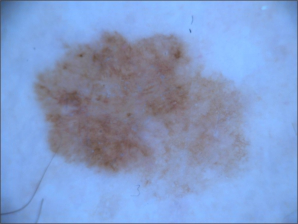

In [43]:
img

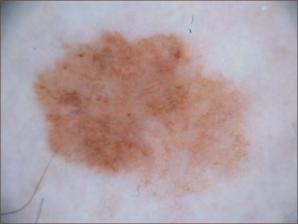

In [46]:
img.apply_tfms(correct_color_max_rgb(gamma=1/2.2))

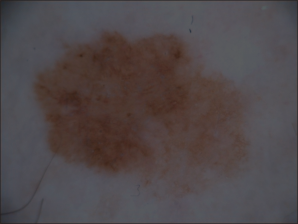

In [54]:
img.apply_tfms(correct_color_max_rgb(gamma=1/2.2))

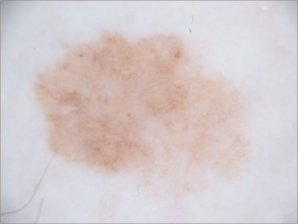

In [51]:
img.apply_tfms(correct_color_max_rgb(gamma=1/2.2))

In [6]:
!python notebook2script-Copy1.py ColorTransforms.ipynb

Converted ColorTransforms.ipynb to exp/nb_ColorTransforms.py


# Testing

In [61]:
from exp import *

In [62]:
dm = DatasetManager('2017',224,'all','2017')

In [63]:
# dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

# Color Balance

In [64]:
train_imgs = dm.get_dataset_path('train_images')

In [65]:
len(dm.get_dataset_path('train_images').ls())

2000

In [66]:
len(dm.get_dataset_path('valid_images').ls())

150

In [67]:
dm.get_label_for_image_path()

TypeError: get_label_for_image_path() missing 1 required positional argument: 'image_path'

In [97]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=64)\
    .normalize()
    return data

data = reload_dataset(dm)

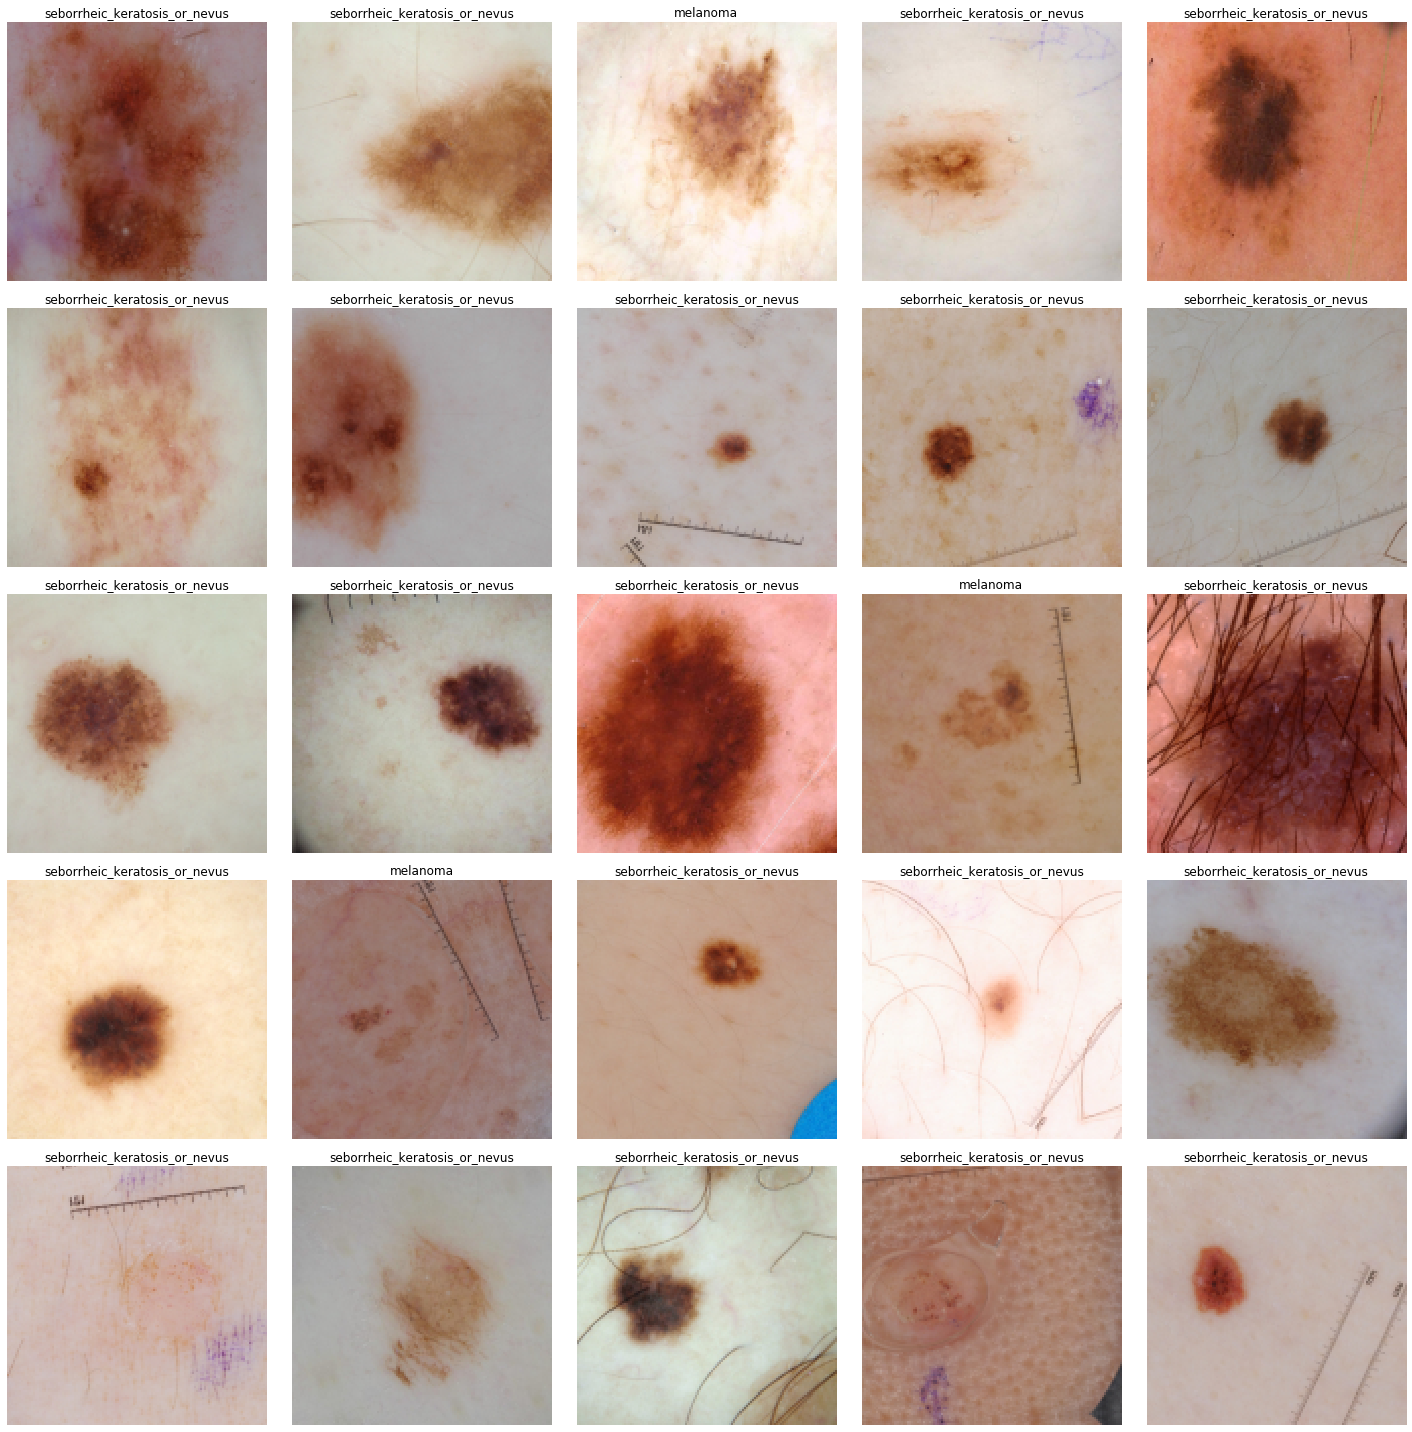

In [98]:
random_seed(1,True)
data.show_batch()

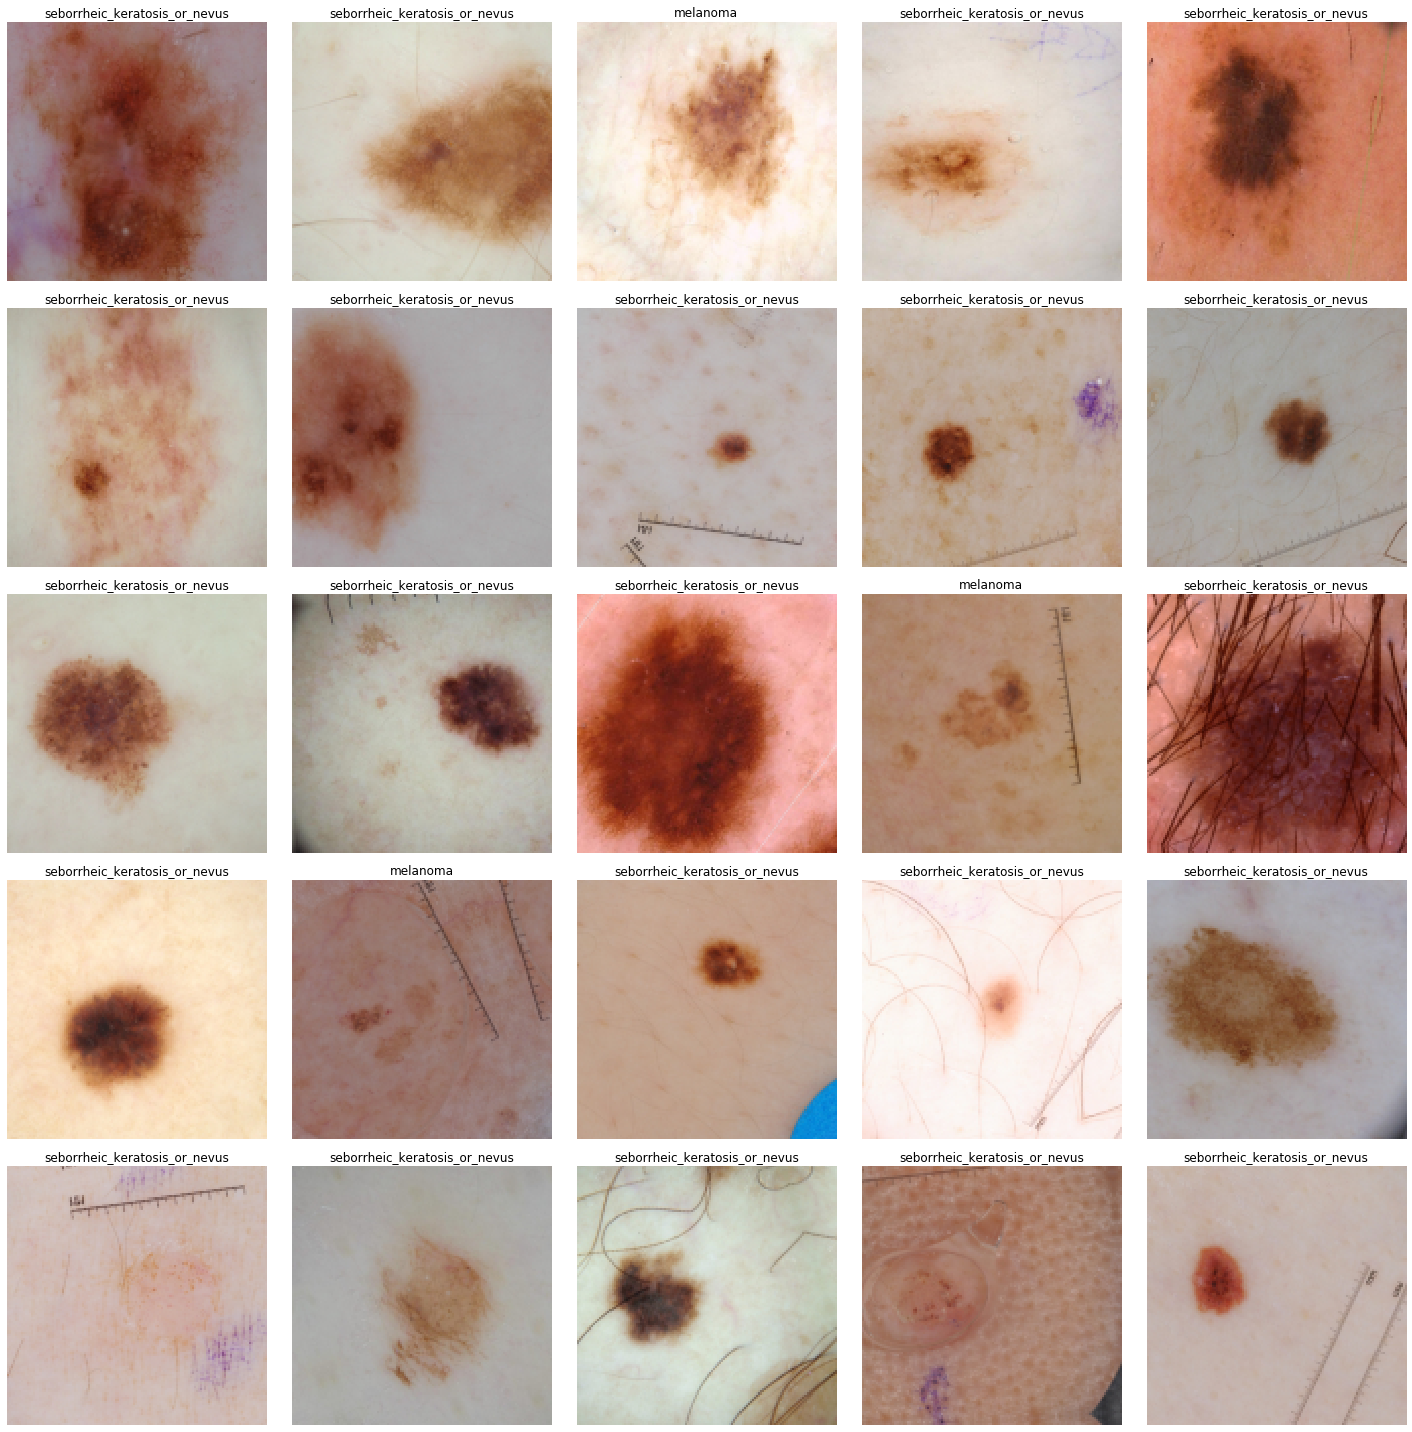

In [99]:
random_seed(1,True)
data.show_batch()

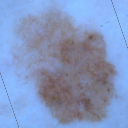

In [71]:
random_seed(1,True)
data.train_ds[1][0]

In [73]:
def _plot(i,j,ax,img_index=0):
    x,y = data.train_ds[img_index]
    x.show(ax, y=y)


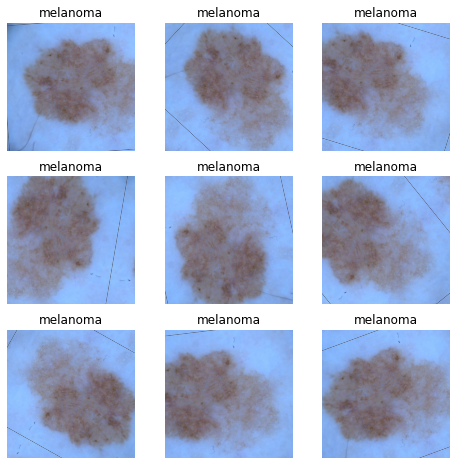

In [74]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

### Max rgb

In [83]:
data = reload_dataset(dm)

In [84]:
correct_color_max_rgb.order = 0
data.train_ds.tfms.insert(0,correct_color_max_rgb(gamma=1/2.2));
data.valid_ds.tfms.insert(0,correct_color_max_rgb(gamma=1/2.2));

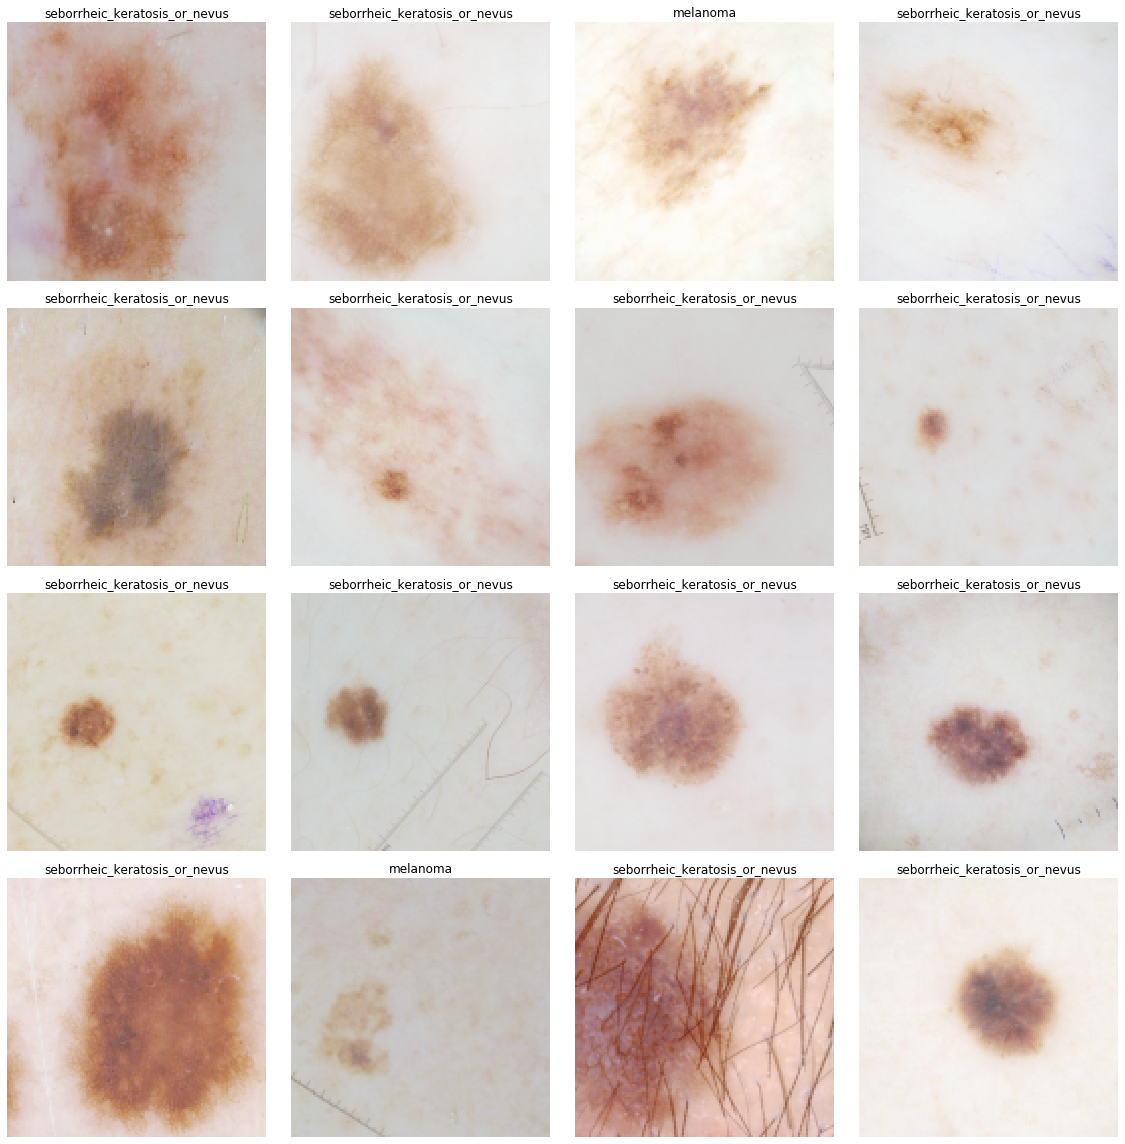

In [90]:
random_seed(1,True)
data.show_batch()

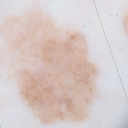

In [86]:
random_seed(1,True)
data.train_ds[1][0]

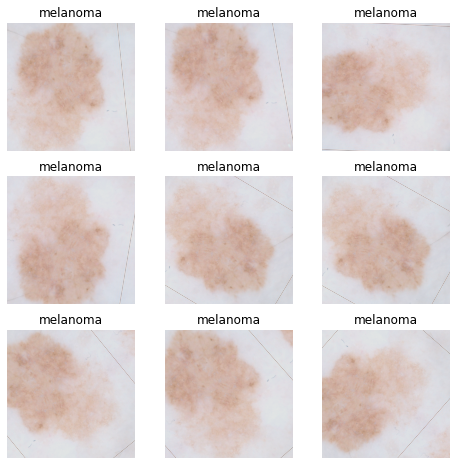

In [87]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))